# Домашнее задание 6: классификация текстов

In [ ]:
# !pip install nltk

In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings

from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from itertools import chain
from nltk.tokenize import TweetTokenizer
from string import punctuation
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings("ignore")

In [ ]:
url = 'https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv'
df = pd.read_csv(url, encoding='latin-1')

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,Positive


## Задание 1. Подготовка датасета (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [ ]:
df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [ ]:
df.loc[(df['Sentiment'] == 'Positive') | (df['Sentiment'] == 'Extremely Positive'), ('Sentiment')] = 1
df.loc[df['Sentiment'] != 1, ('Sentiment')] = 0

In [ ]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1
...,...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,I never that weÃÂd be in a situation &amp; w...,1
33440,44950,89902,NaN,14-04-2020,@MrSilverScott you are definitely my man. I fe...,1
33441,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,0
33442,44953,89905,NaN,14-04-2020,You know itÃÂs getting tough when @KameronWi...,1


In [ ]:
df['Sentiment'].unique()

array([1, 0], dtype=object)

Сбалансированы ли классы?

In [ ]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

In [ ]:
(df['Sentiment'].value_counts() / df.shape[0] * 100).round(2)

Sentiment
1    53.96
0    46.04
Name: count, dtype: float64

**Ответ:** данные сбалансированы неидеально, но осмелюсь предположить, что различие на примерно 8 процентов не сделает большой погоды.

Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [ ]:
df.isna().sum().sum()

7049

Значение выше не равно 0, следовательно, в датасете есть пропуски.

In [ ]:
df = df.fillna('Unknown')

In [ ]:
df.isna().sum().sum()

0

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2. Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
c = Counter(chain.from_iterable(train['OriginalTweet'].apply(lambda tweet: tweet.lower().split())))
df_vocab = pd.DataFrame(c.most_common())

Какой размер словаря получился?

In [ ]:
df_vocab.shape[0]

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [ ]:
df_vocab.head(10)

,0,1
0,the,26815
1,to,23373
2,and,14684
3,of,13012
4,a,11737
5,in,11198
6,for,8566
7,#coronavirus,8223
8,is,7383
9,are,7050


**Ответ:** эти токены находятся в топе потому, что это предлоги или какие-то частицы, которые используются в разговоре очень часто и во множестве всяких разных контекстов. По отдельности они ничего не значат, только лишь придают окраску словам и оборотам, которые находятся рядом с ними. Также в топе есть хэштег коронавирус по понятным причинам (мы все-таки рассматриваем твиты про коронавирус).

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
df_vocab.tail(20)

,0,1
79735,skellig,1
79736,coast!,1
79737,closer!),1
79738,@skelligsix18,1
79739,#skelligcoast2kms,1
79740,#southkerry,1
79741,https://t.co/zjcl195vqs,1
79742,@srinivasiyc,1
79743,https://t.co/iaek4fwsgz,1
79744,premiership,1


**Ответ:** эти слова непопулярны т.к. это какие-то единичные ответы пользователям, странные, не имеющие отношения к тематике датасета хэштеги и слова, а также какие-то непонятные ссылки t.co.


Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [ ]:
tw = TweetTokenizer()

In [ ]:
c = Counter(chain.from_iterable(train['OriginalTweet'].apply(lambda tweet: tw.tokenize(tweet.lower()))))
df_vocab = pd.DataFrame(c.most_common(), columns=['word', 'count'])

In [ ]:
df_vocab.head(10)

,word,count
0,the,26993
1,.,24118
2,to,23478
3,",",17571
4,and,14825
5,of,13044
6,a,11891
7,in,11348
8,?,9524
9,#coronavirus,8808


**Ответ:** в топе появилась пунктуация. TweetTokenizer умеет ее определять и выделять отдельно, правда, сама по себе пунктуация много информации не несет. В топе все так же остались предлоги, правда их количество немного увеличилось. В прошлом топе не было пунктуации т.к. обычно она не выделяется пробелами и получается, что она "прилипала" к другим словам.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
noise = set(stopwords.words('english') + list(punctuation))

In [ ]:
df_vocab = df_vocab[~df_vocab['word'].isin(noise)]
df_vocab.head(10)

,word,count
9,#coronavirus,8808
12,â,7415
13,,7311
14,19,7167
17,covid,6253
23,prices,4601
25,,4372
26,food,4367
29,store,3877
31,supermarket,3805


**Ответ:** да, в словаре все еще есть странные символы, неинтерпретируемые совершенно никак. Скорее всего какие-то служебные символы твиттера или что-то подобное.


Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [ ]:
df_vocab = df_vocab[np.vectorize(lambda a: False if len(a) == 1 and ord(a) >= 128 else True)(df_vocab['word'])]

In [ ]:
df_vocab.head(10)

,word,count
9,#coronavirus,8808
14,19,7167
17,covid,6253
23,prices,4601
26,food,4367
29,store,3877
31,supermarket,3805
36,grocery,3523
38,people,3463
45,#covid19,2589


In [ ]:
df_vocab.tail(20)

,word,count
58328,https://t.co/lw1r0rm7xs,1
58329,https://t.co/5cbliqzx7l,1
58330,now.when,1
58331,milion,1
58332,skellig,1
58333,@skelligsix18,1
58334,#skelligcoast2kms,1
58335,#southkerry,1
58336,https://t.co/zjcl195vqs,1
58337,@srinivasiyc,1


**Ответ:** теперь практически не осталось бессмысленных слов, предлогов и т.д., однако на самый верх топа "всплыло" число 19 (символизирующее 19 год или 19 в названии COVID-19, наверное). Также внизу топа так и остались всякие странные слова, неправильно написанные или какие-то тэги.

Хуже стало то, что мы потеряли часть возможно полезной информации из датасета (например, есть предлоги и частицы, в комбинации с которыми фраза приобретает совершенно другую окраску или смысл, теперь информацией о таких фразах мы не обладаем и смотрим лишь на слова "в вакууме").

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [ ]:
df_vocab[np.vectorize(lambda a: True if a[0] == '#' else False)(df_vocab['word'])].head(10)

,word,count
9,#coronavirus,8808
45,#covid19,2589
73,#covid_19,1734
113,#covid2019,946
145,#toiletpaper,744
172,#covid,641
225,#socialdistancing,465
232,#coronacrisis,448
380,#pandemic,257
392,#coronaviruspandemic,249


**Ответ:** хэштеги являются достаточно популярными словами в твитах пользователей. В особенности популярны все хэштеги так или иначе связанные с ковидом. Также выделяются хэштеги о туалетной бумаге, на фоне всеобщей паники (больше - мемной паники) по поводу того, что туалетной бумаги может не хватить на время локдауна и надо закупаться.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
df_vocab[np.vectorize(lambda a: True if a.find('https://t.co') != -1 else False)(df_vocab['word'])].head(10)

,word,count
8254,https://t.co/oxa7swtond,5
8756,https://t.co/gp3eusapl8,4
10474,https://t.co/deftrui1pfãâ,3
10625,https://t.co/wrlhyzizaa,3
10636,https://t.co/kuwipf1kqw,3
10725,https://t.co/zjnrx6dkkn,3
10854,https://t.co/3gbbdpdjat,3
11010,https://t.co/e2znxajpre,3
11652,https://t.co/catkegayoy,3
11741,https://t.co/g63rp042ho,3


**Ответ:** по сравнению с хэштегами эти ссылки намного-намного менее популярны. Такая информация вряд ли будет хоть как-то полезна в нашей задаче.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co


In [ ]:
noise = stopwords.words('english') + list(punctuation)

def custom_tokenizer(text):
    tokens = pd.Series(TweetTokenizer().tokenize(text.lower()))
    tokens = tokens[np.vectorize(lambda a: not((len(a) == 1 and ord(a) >= 128) or a.startswith('https://t.co') or a in noise))(tokens)]

    return tokens

In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

2           sample
3             text
7     @sample_text
13     #sampletext
dtype: object

## Задание 3. Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [ ]:
cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

45308


In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
X = cv.transform([train.iloc[ind]['OriginalTweet']])
count_vect_df = pd.DataFrame({
    'word': cv.get_feature_names_out(),
    'count': X.toarray()[0]
})

In [ ]:
count_vect_df[count_vect_df['count'] == 1]

,word,count
1833,#coronavirusoutbreak,1
2046,#covid2019,1
16658,@skynews,1
20553,brainless,1
26665,ffs,1
27042,food,1
27233,france,1
31579,lets,1
34079,nice,1
34688,one,1


**Ответ:** честно, не особо понимаю вопрос. Очевидно, что для такого метода определения слов нельзя определить самые важные (особенно в выборке из одного отзыва). Векторайзер просто пометил какие токены есть в твитте, а каких нет, все слова для него одинаковы в "важности" (если это вообще можно так называть).

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
tv = TfidfVectorizer(tokenizer=custom_tokenizer)
tv.fit(train['OriginalTweet'])

X = tv.transform([train.iloc[ind]['OriginalTweet']])
tfidf_vect_df = pd.DataFrame({
    'word': tv.get_feature_names_out(),
    'rarity': X.toarray()[0]
})

In [ ]:
tfidf_vect_df[tfidf_vect_df['rarity'] > 0]

,word,rarity
1833,#coronavirusoutbreak,0.225843
2046,#covid2019,0.168252
16658,@skynews,0.310426
20553,brainless,0.386764
26665,ffs,0.324474
27042,food,0.113289
27233,france,0.320473
31579,lets,0.301211
34079,nice,0.254273
34688,one,0.163067


**Ответ:** самым важным словом по мнению tfidf является brainless, а наименее важным - food. В этом случае, он неплохо определил важные слова.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т.д.)

In [ ]:
tweet = train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)].iloc[1]['OriginalTweet']

In [ ]:
X = tv.transform([tweet])
tfidf_vect_df = pd.DataFrame({
    'word': tv.get_feature_names_out(),
    'rarity': X.toarray()[0]
})

In [ ]:
tfidf_vect_df[tfidf_vect_df['rarity'] > 0]

,word,rarity
10262,19,0.086346
18505,also,0.178619
18544,amazing,0.250035
19901,behind,0.254317
21263,cards,0.280998
22051,click,0.256867
23951,delivered,0.257755
27756,getting,0.197262
31573,let,0.212634
32407,many,0.170508


В данном примере tfidf хорошо выделил важный токен. Самым важным для него оказалось thank, что, скорее всего, действительно окрашивает твит в более положительный оттенок.

## Задание 4. Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [ ]:
X_train, y_train = train.drop('Sentiment', axis=1), train['Sentiment']
X_test, y_test = test.drop('Sentiment', axis=1), test['Sentiment']

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [ ]:
bow = cv.fit_transform(X_train['OriginalTweet'])
bow_test = cv.transform(X_test['OriginalTweet'])

In [ ]:
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(bow, y_train)

pred_train = clf.predict(bow)
pred_test = clf.predict(bow_test)

In [ ]:
print("Accuracy on train:", accuracy_score(y_train, pred_train))
print("Accuracy on test:", accuracy_score(y_test, pred_test))

Accuracy on train: 0.9844510892780863
Accuracy on test: 0.8672513454255532


In [ ]:
vec_train = tv.fit_transform(X_train['OriginalTweet'])
vec_test = tv.transform(X_test['OriginalTweet'])

In [ ]:
clf.fit(vec_train, y_train)

pred_train = clf.predict(vec_train)
pred_test = clf.predict(vec_test)

In [ ]:
print("Accuracy on train:", accuracy_score(y_train, pred_train))
print("Accuracy on test:", accuracy_score(y_test, pred_test))

Accuracy on train: 0.9254592054677488
Accuracy on test: 0.8531991229818616


Лучший результат показал CountVectorizer, хотя он не прямо уж сильно лучше, чем TF-IDF. Модели в целом выглядят не совсем уж глупыми, скорее разумными, показывают хороший результат.

## Задание 5. Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря? Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
stemmer = SnowballStemmer("english")

In [ ]:
def custom_stem_tokenizer(text):
    return [stemmer.stem(token) for token in custom_tokenizer(text)]

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)

bow_train = cv.fit_transform(X_train['OriginalTweet'])
bow_test = cv.transform(X_test['OriginalTweet'])

In [ ]:
clf.fit(bow_train, y_train)

pred_train = clf.predict(bow_train)
pred_test = clf.predict(bow_test)

In [ ]:
print("Accuracy on train:", accuracy_score(y_train, pred_train))
print("Accuracy on test:", accuracy_score(y_test, pred_test))

Accuracy on train: 0.9718923536950022
Accuracy on test: 0.8672513454255532


In [ ]:
tv = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

vec_train = tv.fit_transform(X_train['OriginalTweet'])
vec_test = tv.transform(X_test['OriginalTweet'])

In [ ]:
clf.fit(vec_train, y_train)

pred_train = clf.predict(vec_train)
pred_test = clf.predict(vec_test)

In [ ]:
print("Accuracy on train:", accuracy_score(y_train, pred_train))
print("Accuracy on test:", accuracy_score(y_test, pred_test))

Accuracy on train: 0.9158906450234943
Accuracy on test: 0.8560892963922663


In [ ]:
print(len(cv.vocabulary_))

36652


**Ответ:** размер словаря закономерно уменьшился (т.к. у всех слов были урезаны окончания и некоторые "слились" в одно слово). На качество модели стемминг практически не повлиял, в нашем случае наоборот - сделал только хуже, так что смысла в нем особого в нашей задаче нет.

## Задание 6. Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.

Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df = 0.3).fit(X_train['OriginalTweet'])
print(len(cv_df.vocabulary_))

36651


Параметр получился ни большим ни маленьким (по моему мнению). Вполне логично, что какое-то слово встречается примерно одно через два.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=0.00045).fit(X_train['OriginalTweet'])
print(len(cv_df.vocabulary_))

3700


In [ ]:
bow_train = cv_df.fit_transform(X_train['OriginalTweet'])
bow_test = cv_df.transform(X_test['OriginalTweet'])

In [ ]:
clf.fit(bow_train, y_train)

pred_train = clf.predict(bow_train)
pred_test = clf.predict(bow_test)

In [ ]:
print("Accuracy on train:", accuracy_score(y_train, pred_train))
print("Accuracy on test:", accuracy_score(y_test, pred_test))

Accuracy on train: 0.9286629645450662
Accuracy on test: 0.8680486346422165


Качество, конечно, осталось не точно таким же как и было, но оно не ухудшилось (а даже немного улучшилось). Правда, на трейне качество немного упало, но это не совсем важно.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [ ]:
scaler = StandardScaler(with_mean=False)

In [ ]:
bow_train = scaler.fit_transform(bow_train)
bow_test = scaler.transform(bow_test)

In [ ]:
clf.fit(bow_train, y_train)

pred_train = clf.predict(bow_train)
pred_test = clf.predict(bow_test)

In [ ]:
print("Accuracy on train:", accuracy_score(y_train, pred_train))
print("Accuracy on test:", accuracy_score(y_test, pred_test))

Accuracy on train: 0.9416915847928236
Accuracy on test: 0.8446282639027307


In [ ]:
tokens = cv_df.get_feature_names_out()
weights = list(zip(tokens, clf.coef_[0]))

weights_lowest = pd.DataFrame(sorted(weights, key=lambda x: x[1])[:10], columns=['word', 'weight'])
weights_highest = pd.DataFrame(sorted(weights, key=lambda x: x[1], reverse=True)[:10], columns=['word', 'weight'])

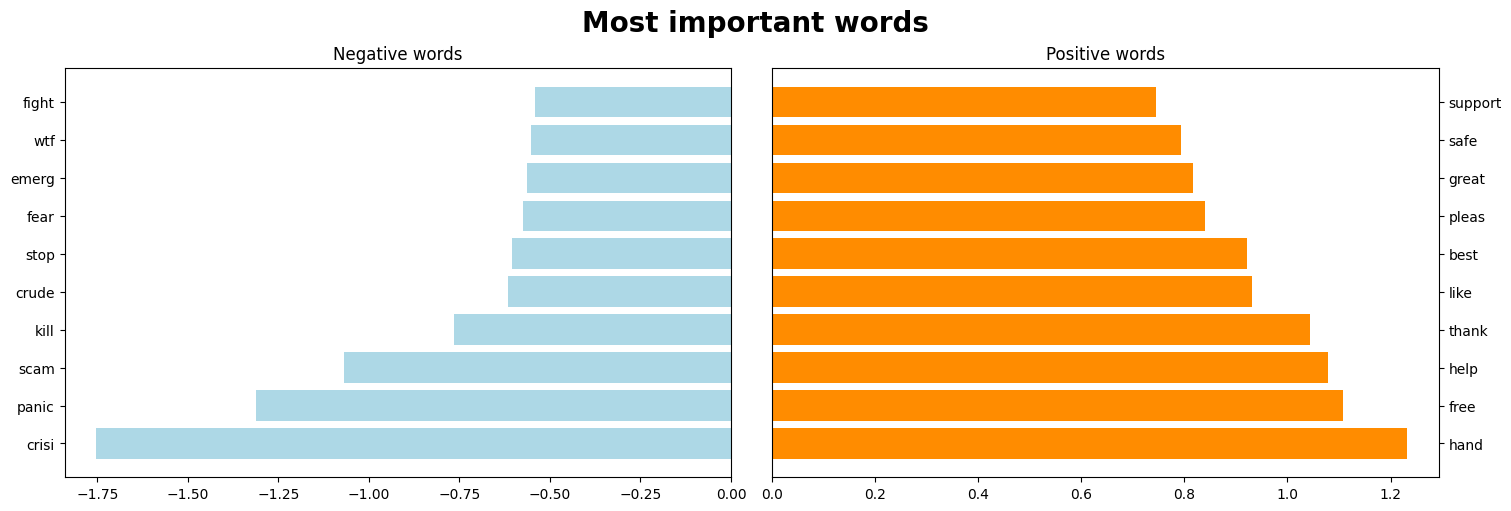

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), layout="compressed")

fig.suptitle('Most important words', fontsize=20, fontweight='bold')
axes[0].set_title('Negative words')
axes[1].set_title('Positive words')

axes[0].barh(weights_lowest['word'], weights_lowest['weight'], align='center', color='lightblue')
axes[1].barh(weights_highest['word'], weights_highest['weight'], align='center', color='darkorange')

axes[1].yaxis.tick_right()
axes[1].tick_params(labelright=True, labelleft=False)

Про веса можно сказать, что они хорошо отражают слова, которые сильнее всего влияют на окраску текста. В "топе" отрицательно окрашенных слов по мнению модели находятся действительно отрицательно окрашенные слова (например, кризис, паника, скам). В положительно окрашенных в топ вышли такие слова как свобода, благодарность, рука (скорее всего помощи).

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
train.corr(numeric_only=True)

,UserName,ScreenName,Sentiment
UserName,1.000000,1.000000,0.054568
ScreenName,1.000000,1.000000,0.054568
Sentiment,0.054568,0.054568,1.000000


**Ответ:** нахожу данную корреляцию с целевой переменной очень слабой, поэтому, на мой взгляд, эти признаки бесполезны.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

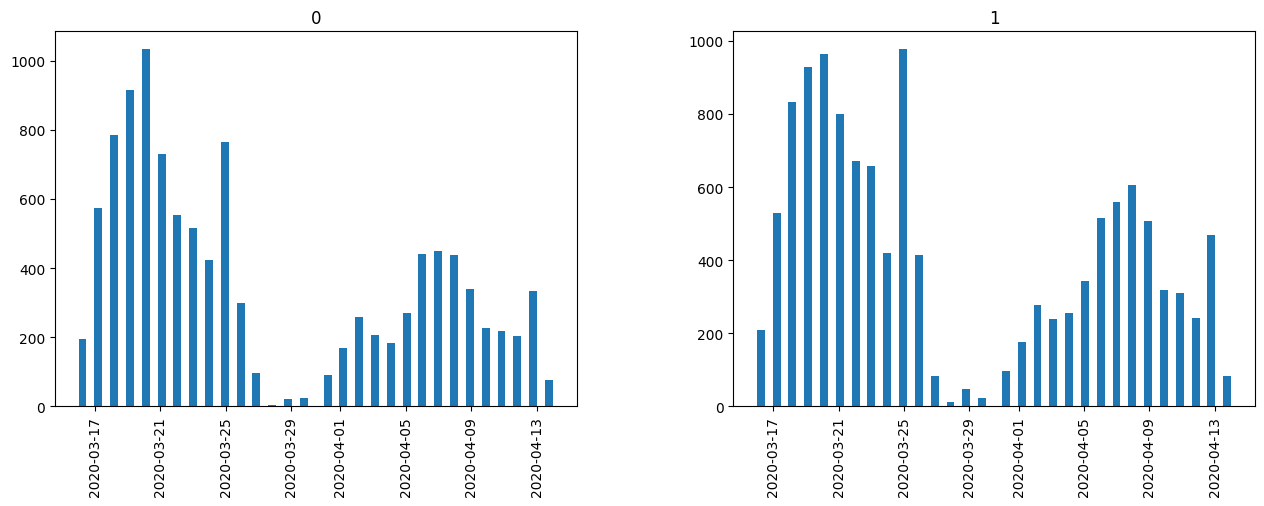

In [ ]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')
hist = train['TweetAt'].hist(bins=60, xrot=90, by=train['Sentiment'], figsize=(15, 5))

**Ответ:** оба графика (как с отрицательно окрашенными твитами, так и с положительно окрашенными) имеют практически идентичный вид, следовательно, можно сделать вывод, что адекватно выделить какие-то зависимости целевой переменной от даты твитта невозможно.

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
len(train['Location'].unique())

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

In [ ]:
values = train['Location'].value_counts().nlargest(11)[1:]

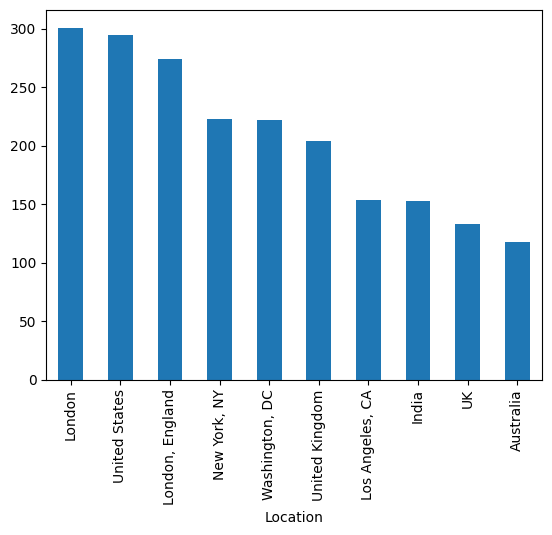

In [ ]:
plt = values.plot.bar()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [ ]:
train['WiderLocation'] = train.apply(lambda row: list(reversed(row['Location'].split(', ')))[0], axis=1)
len(train['WiderLocation'].unique())

4921

In [ ]:
values = train['WiderLocation'].value_counts().nlargest(11)[1:]

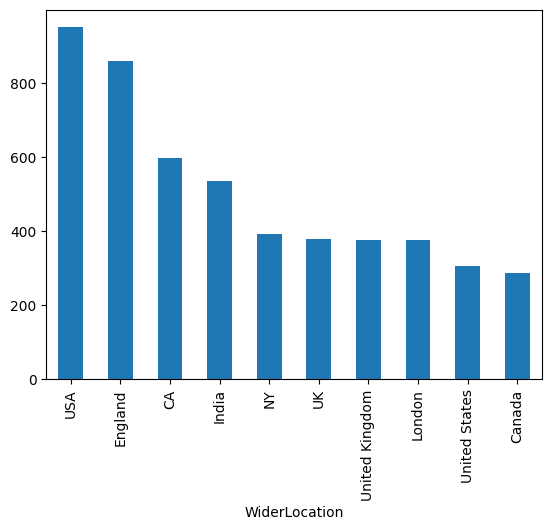

In [ ]:
plt = values.plot.bar()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?

In [ ]:
values = train['WiderLocation'].value_counts()
frequent_places = values[values > 1]
len(frequent_places)

1010

In [ ]:
test['WiderLocation'] = test.apply(lambda row: row['Location'].split(', ')[-1], axis=1)

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?

In [ ]:
df_train = train.copy()
df_test = test.copy()

In [ ]:
df_train['WiderLocation'] = df_train['WiderLocation'].apply(lambda place: place if place in frequent_places else "Unknown")
df_test['WiderLocation'] = df_test['WiderLocation'].apply(lambda place: place if place in frequent_places else "Unknown")

In [ ]:
X_train, y_train = df_train.drop('Sentiment', axis=1), df_train['Sentiment']
X_test, y_test = df_test.drop('Sentiment', axis=1), df_test['Sentiment']

In [ ]:
enc = OneHotEncoder(categories=[frequent_places.index.tolist()])

In [ ]:
X_train_encoded = enc.fit_transform(X_train[['WiderLocation']])
X_test_encoded = enc.transform(X_test[['WiderLocation']])

train_matrix = np.asarray(np.hstack([X_train_encoded.todense(), bow_train.todense()]))
test_matrix = np.asarray(np.hstack([X_test_encoded.todense(), bow_test.todense()]))

In [ ]:
clf.fit(train_matrix, y_train)

pred_train = clf.predict(train_matrix)
pred_test = clf.predict(test_matrix)

In [ ]:
print("Accuracy on train:", accuracy_score(y_train, pred_train))
print("Accuracy on test:", accuracy_score(y_test, pred_test))

Accuracy on train: 0.9456215292609996
Accuracy on test: 0.8443292804464819


Признак полностью бесполезен - качество только упало.